# Exercise 3 | Market Risk

Actuarial Science Undergratuate Program | Business Faculty | Financial Risks Class | José Enrique Pérez Salvador

Based on the context of Exercise 2, you want to estimate the annual volatility of JPMORGAN CHASE & CO.'s stock listed on the NYSE (ticker JPM). You will consider the price series from August 16, 2017 to September 3rd, 2024, and the calendar of business days in Mexico.
Let $ S_t $, $ t=0,1,...,n $ the JPM stock price, let $ X_1,...,X_n $ its daily logreturns series computed as $ X_t = \ln⁡(S_t/S_{t-1})$, $ t=1,...,n $. Our goal is to model $ X_t $.


## Import

In [16]:
proc sql;
%if %sysfunc(exist(WORK.'transform'n)) %then %do;
    drop table WORK.'transform'n;
%end;
%if %sysfunc(exist(WORK.'transform'n,VIEW)) %then %do;
    drop view WORK.'transform'n;
%end;
quit;

FILENAME REFFILE DISK '/export/viya/homes/perez-jose@lasallistas.org.mx/FinancialRisks/RetJPM.xlsx';


PROC IMPORT DATAFILE=REFFILE
	DBMS=XLSX
	OUT=WORK.'transform'n;
	GETNAMES=YES;
RUN;

PROC CONTENTS DATA=WORK.'transform'n; RUN;


 ## Exploration


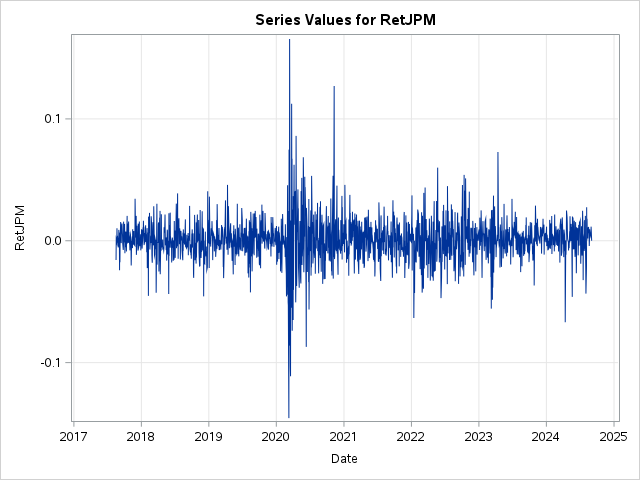
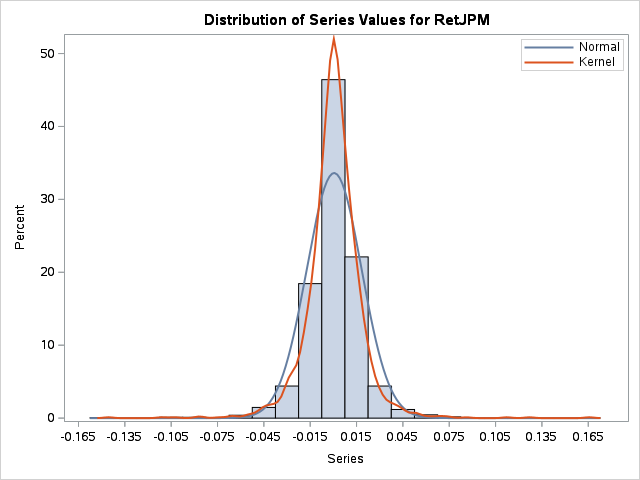
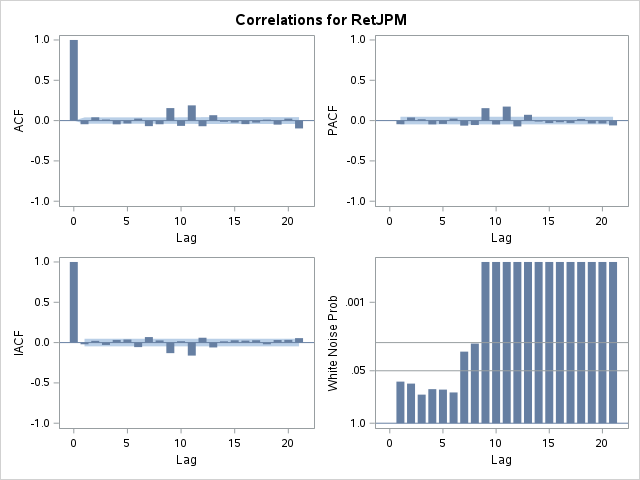

In [17]:
ods graphics / imagemap=on;

proc sort data=WORK.TRANSFORM(keep=date RetJPM) out=Work.preProcessedData;
	by date;
run;

proc timeseries data=Work.preProcessedData seasonality=7 plots=(series 
		histogram corr);
	id date interval=Day;
	var RetJPM / accumulate=none transform=none;
run;

proc delete data=Work.preProcessedData;
run;

## Model


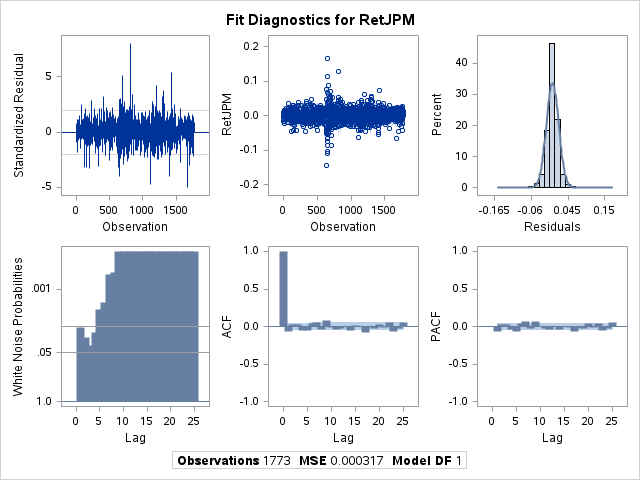
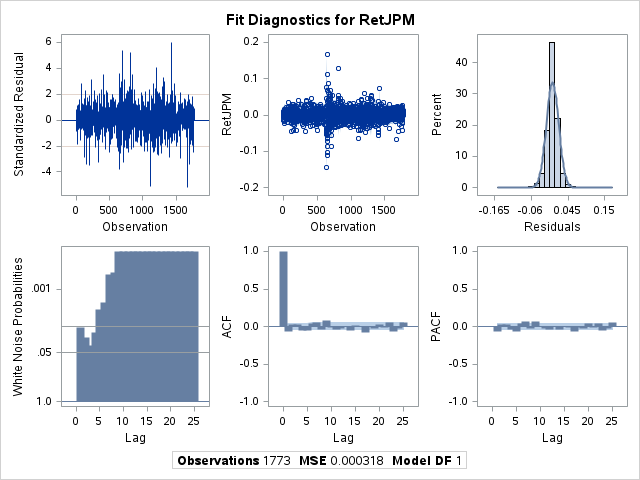
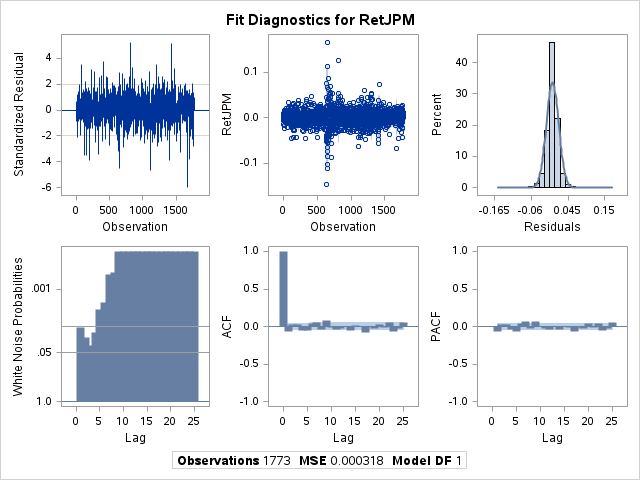
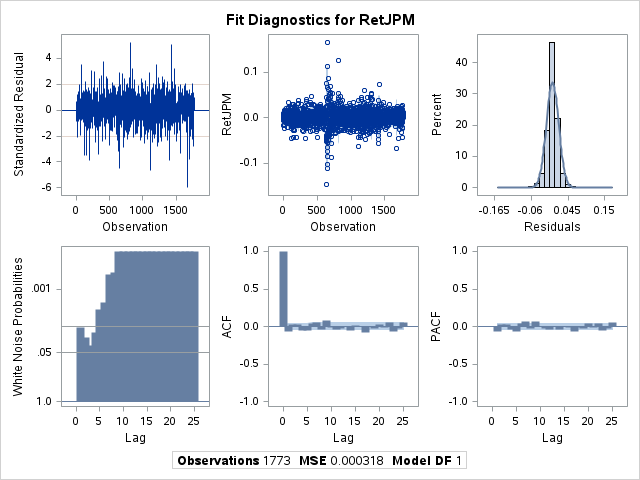
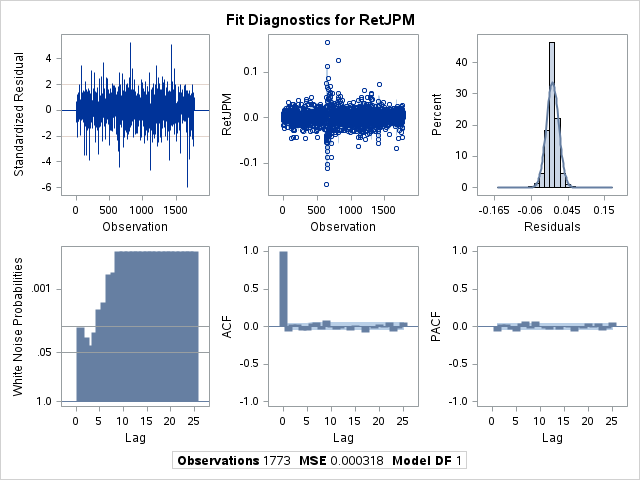
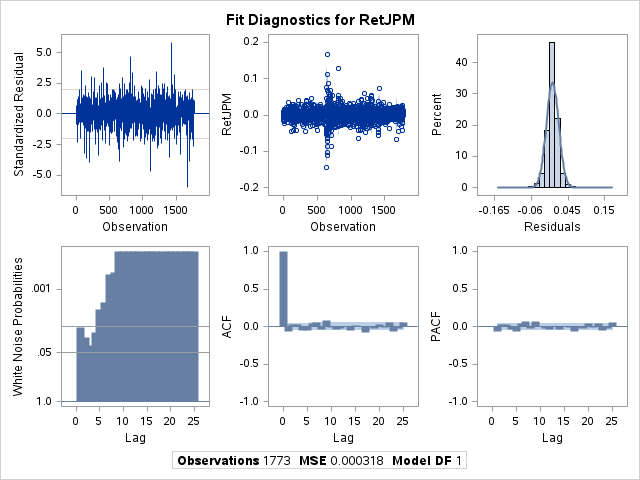

In [18]:
ods output FitSummary=FIT_SUMMARY ParameterEstimates = PARAMETER_ESTIMATES ;
proc autoreg data=work.transform(keep=date RetJPM) maxit=200 optimizer=nlp;
	"ARCH(p=1)": model RetJPM=/ garch=(q=1) noint;
	output out=results_arch1 cev=v;
	"ARCH(p=2)": model RetJPM=/ garch=(q=2) noint;
	output out=results_arch2 cev=v;
	"GARCH(p=1,q=1)": model RetJPM=/ garch=(q=1,p=1) noint;
	output out=results_garch_1_1 cev=v;
	"GARCH(p=1,q=2)": model RetJPM=/ garch=(q=1,p=2) noint;
	output out=results_garch_1_2 cev=v;
	"GARCH(p=2,q=1)": model RetJPM=/ garch=(q=2,p=1) noint;
	output out=results_garch_2_1 cev=v;
	"GARCH(p=2,q=2)": model RetJPM=/ garch=(q=2,p=2) noint;
	output out=results_garch_2_2 cev=v;
run;

## Selection the best model based on the AICC

In [20]:
proc sql;
	select model, label2, nvalue2
	from FIT_SUMMARY
	where label2 = "AICC"
	having min(nvalue2)=nvalue2
	;
quit;

374  ods listing close;ods html5 (id=saspy_internal) options(bitmap_mode='inline') device=svg style=HTMLBlue; ods graphics on /
374! outputfmt=png;
375  
376  proc sql;
377  	select model, label2, nvalue2
378  	from FIT_SUMMARY
379  	where label2 = "AICC"
380  	having min(nvalue2)=nvalue2
381  	;
NOTE: The query requires remerging summary statistics back with the original data.
382  quit;
NOTE: PROCEDURE SQL used (Total process time):
      real time           0.00 seconds
      cpu time            0.01 seconds
      

383  ods html5 (id=saspy_internal) close;ods listing;
384  




Get the estimated volatility with the champion model

In [21]:
proc sql;
	create table work.var_cond as
	select a.date
	, a.v as variance label="Conditional variance with GARCH(1,1)"
	, (252*a.v)**0.5 as vol label="Annual volatility"
	from work.results_garch_1_1 a 
	;
quit;

385  ods listing close;ods html5 (id=saspy_internal) options(bitmap_mode='inline') device=svg style=HTMLBlue; ods graphics on /
385! outputfmt=png;
NOTE: Writing HTML5(SASPY_INTERNAL) Body file: sashtml17.htm
386  
387  proc sql;
388  	create table work.var_cond as
389  	select a.date
390  	, a.v as variance label="Conditional variance with GARCH(1,1)"
391  	, (252*a.v)**0.5 as vol label="Annual volatility"
392  	from work.results_garch_1_1 a
393  	;
NOTE: Table WORK.VAR_COND created, with 1774 rows and 3 columns.

394  quit;
NOTE: PROCEDURE SQL used (Total process time):
      real time           0.00 seconds
      cpu time            0.00 seconds
      

395  ods html5 (id=saspy_internal) close;ods listing;
396  




Plot the estimated volatilities

In [22]:
ods graphics / reset width=6.4in height=4.8in imagemap noborder;

proc sort data=work.var_cond out=_SeriesPlotTaskData;
	by date;
run;

proc sgplot data=_SeriesPlotTaskData;
	title height=14pt "Volatilidad";
	series x=date y=vol /;
	xaxis grid;
	yaxis grid;
run;

ods graphics / reset;
title;

proc datasets library=WORK noprint;
	delete _SeriesPlotTaskData;
run;